In [1]:
import pathlib

import pandas as pd

In [2]:
file_path = pathlib.Path(
    "/Users/ruppik/git-source/Topo_LLM/data/analysis/sample_sizes/run_general_comparisons/analysis/twonn/",
    "data-multiwoz21_split-validation_ctxt-dataset_entry_samples-3000_feat-col-ner_tags/",
    "lvl-token/add-prefix-space-True_max-len-512/model-roberta-base_task-masked_lm/layer--1_agg-mean/norm-None/full_local_estimates_df.csv",
)

results_base_directory_path: pathlib.Path = file_path.parent

local_estimates_df: pd.DataFrame = pd.read_csv(
    filepath_or_buffer=file_path,
)

local_estimates_df

,Unnamed: 0,path,array_name,array_data,data_prep_sampling_method,data_prep_sampling_seed,data_prep_sampling_samples,local_estimates_description,local_estimates_samples,zerovec,deduplication,neighbors_mode,n_neighbors,num_elements,array_data_truncated,array_data_mean,array_data_std,array_data_truncated_mean,array_data_truncated_std
0,1,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[6.23555437 8.0149704 8.15209756 ... 6.758563...,random,44,20000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[6.23555437 8.0149704 8.15209756 ... 6.758563...,7.833903,1.755342,7.833903,1.755342
1,3,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 9.58667384 7.21474918 10.6036001 ... 7.97...,random,57,30000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 9.58667384 7.21474918 10.6036001 ... 7.97...,8.475106,1.826890,8.475106,1.826890
2,5,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 5.34776325 8.0290216 5.18452183 ... 9.01...,random,43,60000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 5.34776325 8.0290216 5.18452183 ... 9.01...,8.090776,2.671677,8.090776,2.671677
3,7,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[10.77666269 6.28105495 7.82063811 ... 8.78...,random,44,30000,twonn,7500,keep,array_deduplicator,absolute,16,7500,[10.77666269 6.28105495 7.82063811 ... 8.62...,7.753500,3.780621,7.691760,3.643069
4,8,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 7.54057 10.32816405 6.4128736 ... 6.45...,random,44,30000,twonn,7500,keep,array_deduplicator,absolute,128,7500,[ 7.54057 10.32816405 6.4128736 ... 14.01...,8.482894,2.515279,8.602301,2.562843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,369,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[7.06010503 7.2024309 8.78226994 ... 7.577289...,random,45,20000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[7.06010503 7.2024309 8.78226994 ... 7.577289...,7.775308,1.681070,7.775308,1.681070
296,371,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 6.6663343 11.53367151 12.54709542 ... 10.79...,random,46,50000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 6.6663343 11.53367151 12.54709542 ... 10.79...,8.517663,2.129492,8.517663,2.129492
297,373,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 7.25677717 6.57424562 7.2794162 ... 10.84...,random,42,40000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 7.25677717 6.57424562 7.2794162 ... 10.84...,7.981545,1.762259,7.981545,1.762259
298,375,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 5.51246339 6.11611736 8.57374208 ... 7.01...,random,42,50000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 5.51246339 6.11611736 8.57374208 ... 7.01...,8.071080,1.624604,8.071080,1.624604


In [7]:
# Select a subset of the data with the same parameters.
# This allows comparing over different seeds.

n_neighbors_fixed = 256

subset_local_estimates_df: pd.DataFrame = local_estimates_df.copy()

subset_local_estimates_df = subset_local_estimates_df[
    subset_local_estimates_df["data_prep_sampling_method"] == "random"
]

subset_local_estimates_df = subset_local_estimates_df[
    subset_local_estimates_df["deduplication"] == "array_deduplicator"
]

subset_local_estimates_df = subset_local_estimates_df[subset_local_estimates_df["data_prep_sampling_samples"] == 30000]

# subset_local_estimates_df = subset_local_estimates_df[subset_local_estimates_df["local_estimates_samples"] == 2500]

subset_local_estimates_df = subset_local_estimates_df[subset_local_estimates_df["n_neighbors"] == n_neighbors_fixed]

subset_local_estimates_df

,Unnamed: 0,path,array_name,array_data,data_prep_sampling_method,data_prep_sampling_seed,data_prep_sampling_samples,local_estimates_description,local_estimates_samples,zerovec,deduplication,neighbors_mode,n_neighbors,num_elements,array_data_truncated,array_data_mean,array_data_std,array_data_truncated_mean,array_data_truncated_std
1,3,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 9.58667384 7.21474918 10.6036001 ... 7.97...,random,57,30000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 9.58667384 7.21474918 10.6036001 ... 7.97...,8.475106,1.826890,8.475106,1.826890
6,10,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 8.04055102 10.2153563 7.07903249 ... 8.48...,random,44,30000,twonn,7500,keep,array_deduplicator,absolute,256,7500,[ 8.04055102 10.2153563 7.07903249 ... 12.96...,8.653155,2.268156,8.726880,2.301384
13,18,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 9.29957835 11.33341927 7.74508875 ... 12.69...,random,44,30000,twonn,15000,keep,array_deduplicator,absolute,256,15000,[ 9.29957835 11.33341927 7.74508875 ... 11.88...,8.764652,2.138071,8.852580,2.167418
20,26,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 7.09701923 11.66634982 8.49906977 ... 12.42...,random,44,30000,twonn,12500,keep,array_deduplicator,absolute,256,12500,[ 7.09701923 11.66634982 8.49906977 ... 11.69...,8.811487,2.076360,8.901511,2.094605
27,34,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 6.56201107 8.15065459 6.33231467 ... 10.33...,random,44,30000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[ 6.56201107 8.15065459 6.33231467 ... 10.33...,7.902354,1.831746,7.902354,1.831746
34,42,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[6.96611318 9.2033238 8.36061042 ... 9.084807...,random,44,30000,twonn,5000,keep,array_deduplicator,absolute,256,5000,[ 6.96611318 9.2033238 8.36061042 ... 11.09...,8.463901,2.218026,8.515797,2.262058
41,50,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 7.72667023 11.38724923 8.77412744 ... 11.19...,random,44,30000,twonn,10000,keep,array_deduplicator,absolute,256,10000,[ 7.72667023 11.38724923 8.77412744 ... 11.85...,8.812581,2.130717,8.874669,2.167638
45,55,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[10.23243265 13.12754042 6.13845151 ... 6.15...,random,53,30000,twonn,2500,keep,array_deduplicator,absolute,256,2500,[10.23243265 13.12754042 6.13845151 ... 6.15...,8.193742,2.197088,8.193742,2.197088
53,68,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[ 8.62238752 6.08379788 12.97614564 ... 6.04...,random,43,30000,twonn,7500,keep,array_deduplicator,absolute,256,7500,[ 8.62238752 6.08379788 12.97614564 ... 6.40...,8.358433,2.367228,8.467067,2.402817
60,76,/Users/ruppik/git-source/Topo_LLM/data/analysi...,local_estimates_pointwise.npy,[12.11512638 7.75908089 13.19302281 ... 8.86...,random,43,30000,twonn,15000,keep,array_deduplicator,absolute,256,15000,[12.11512638 7.75908089 13.19302281 ... 7.59...,8.808589,2.184880,8.871984,2.194502


In [8]:
subset_local_estimates_df.describe()

,Unnamed: 0,data_prep_sampling_seed,data_prep_sampling_samples,local_estimates_samples,n_neighbors,num_elements,array_data_mean,array_data_std,array_data_truncated_mean,array_data_truncated_std
count,45.000000,45.000000,45.0,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.000000
mean,181.711111,47.333333,30000.0,6666.666667,256.0,6666.666667,8.464970,2.046178,8.476474,2.046263
std,108.488714,5.518564,0.0,4615.930912,0.0,4615.930912,0.346738,0.212275,0.355067,0.212681
min,3.000000,42.000000,30000.0,2500.000000,256.0,2500.000000,7.642948,1.541462,7.642948,1.541462
25%,92.000000,43.000000,30000.0,2500.000000,256.0,2500.000000,8.292356,1.902471,8.290219,1.902471
50%,175.000000,45.000000,30000.0,5000.000000,256.0,5000.000000,8.521235,2.076360,8.507624,2.093167
75%,266.000000,50.000000,30000.0,10000.000000,256.0,10000.000000,8.779461,2.218026,8.764800,2.230838
max,367.000000,61.000000,30000.0,15000.000000,256.0,15000.000000,8.928240,2.367228,8.951244,2.402817


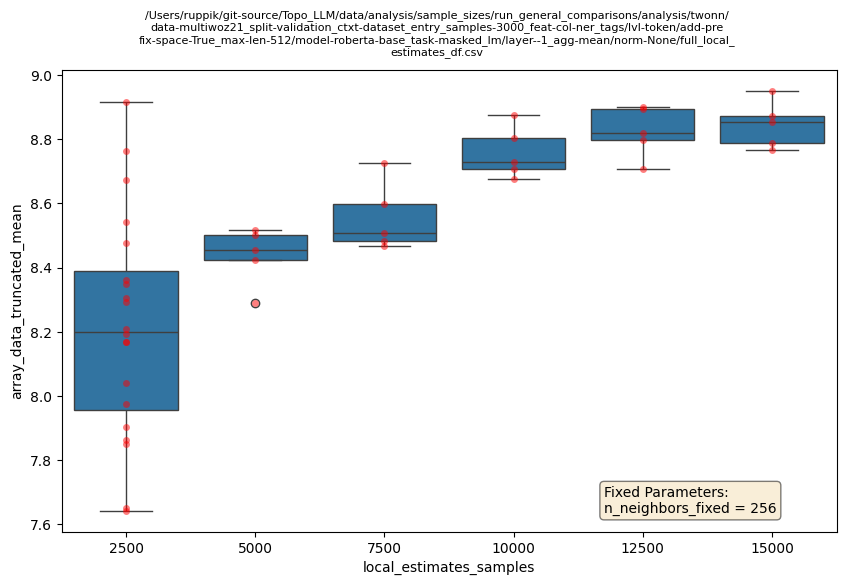

In [13]:
# Create a boxplot of the 'array_data_truncated_mean' values
# in the subset_local_estimates_df

import matplotlib.pyplot as plt
import seaborn as sns

from topollm.analysis.compare_sampling_methods.make_plots import add_subtitle

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="local_estimates_samples",
    y="array_data_truncated_mean",
    data=subset_local_estimates_df,
)
sns.stripplot(
    x="local_estimates_samples",
    y="array_data_truncated_mean",
    data=subset_local_estimates_df,
    color="red",
    jitter=False,
    dodge=True,
    marker="o",
    alpha=0.5,
)

# Adding additional information about the fixed parameters in the plot
fixed_params_text: str = "\n".join([f"{n_neighbors_fixed = }"])
plt.text(
    x=0.7,
    y=0.1,
    s=f"Fixed Parameters:\n{fixed_params_text}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox={
        "boxstyle": "round",
        "facecolor": "wheat",
        "alpha": 0.5,
    },
)

add_subtitle(
    additional_title=str(object=file_path),
)

plt.show()